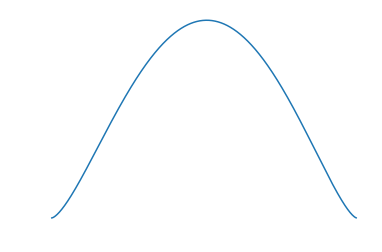

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

fig, ax = plt.subplots(1, 1)
a, b = 2.5, 2.45
plt.axis('off')

x = np.arange(0, 1, 0.001)

plt.plot(x, beta.pdf(x, a, b))
plt.savefig('beta.svg', format = 'svg')

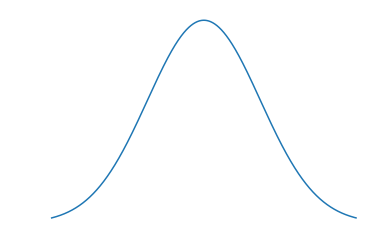

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x_axis = np.arange(-2.7, 2.7, 0.001)
plt.axis('off')

plt.plot(x_axis, norm.pdf(x_axis,0,1))
plt.savefig('norm.svg', format = 'svg')

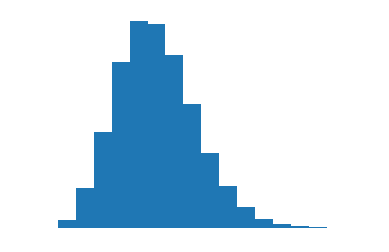

In [142]:
import numpy as np
import matplotlib.pyplot as plt

poisson = np.random.poisson(5, 80000)
plt.axis('off')
plt.hist(poisson, 17, normed=True)
plt.savefig('poisson.svg', format = 'svg')

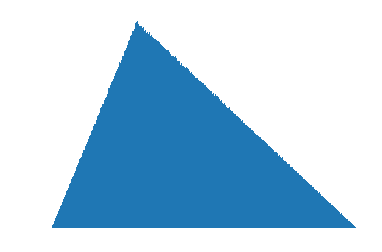

In [139]:
import numpy as np
import matplotlib.pyplot as plt

triangle = plt.hist(np.random.triangular(0,0.28, 1, 10000000), bins = 500, normed = True)
plt.axis('off')
plt.show()
plt.savefig('triangle.svg', format = 'svg')

#mu = 0
#sigma = 1
#x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
#plt.plot(x, mlab.normpdf(x, mu, sigma))

#beta = np.random.beta(0.5, 0.5)
#x = np.linspace(0, 1)
#plt.plot(beta)

'''
samples = np.random.normal(mu, sigma, 100000)

count, bins, ignored = plt.hist(samples, 100, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2)))
plt.savefig('test.svg', format='svg')
'''